# Session 11 - CAMs, LRs, and Optimizers

This assignment is based on - https://github.com/kuangliu/pytorch-cifar

In [1]:
! git clone https://github.com/divyamarora910/deep-learning-school-of-ai.git

Cloning into 'deep-learning-school-of-ai'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 281 (delta 65), reused 0 (delta 0), pack-reused 157
Receiving objects: 100% (281/281), 678.77 KiB | 6.34 MiB/s, done.
Resolving deltas: 100% (127/127), done.


In [2]:
%ls

deep-learning-school-of-ai/  sample_data/


In [3]:
%cd deep-learning-school-of-ai

/content/deep-learning-school-of-ai


In [4]:
%ls

README.md   session11/  session5/  session7/
session10/  session4/   session6/  session8/


In [5]:
from session11.resnet import ResNet18
from session11.utils import (get_train_transforms,\
                             get_test_transforms,\
                             )

In [6]:
from __future__ import print_function
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [7]:
!pip install torch-lr-finder
!pip install torchsummary
!pip install albumentations

In [8]:
from torchsummary import summary

In [9]:
class Cifar10SearchDataset(datasets.CIFAR10):

    def __init__(self, root="~/data", train=True, download=True, transform=None):

        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):

        image, label = self.data[index], self.targets[index]

        if self.transform is not None:

            transformed = self.transform(image=image)

            image = transformed["image"]

        return image, label

In [10]:
train_transforms, test_transforms = get_train_transforms(),get_test_transforms()

In [11]:
train = Cifar10SearchDataset(root='./data', train=True,
                                        download=True, transform=train_transforms)
test = Cifar10SearchDataset(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:01<00:00, 102333590.56it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


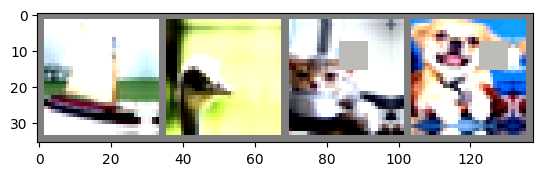

ship  bird  cat   dog  


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [14]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.65E-02


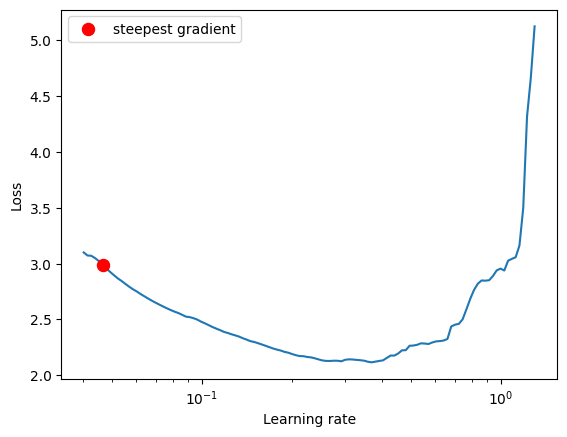

In [15]:
from torch_lr_finder import LRFinder

model = ResNet18().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.03, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [16]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
        optimizer,
        max_lr=5.07E-02,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )



In [17]:
from session11.main import train,test
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, scheduler, criterion)
    test(model, device, test_loader, criterion)

EPOCH: 0


Loss=1.3725765943527222 Batch_id=97 Accuracy=42.08: 100%|██████████| 98/98 [00:49<00:00,  2.00it/s]



Test set: Average loss: 0.0031, Accuracy: 4633/10000 (46.33%)

EPOCH: 1


Loss=1.146949291229248 Batch_id=97 Accuracy=56.14: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]



Test set: Average loss: 0.0031, Accuracy: 4961/10000 (49.61%)

EPOCH: 2


Loss=1.1972841024398804 Batch_id=97 Accuracy=62.93: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]



Test set: Average loss: 0.0031, Accuracy: 5123/10000 (51.23%)

EPOCH: 3


Loss=0.8303530812263489 Batch_id=97 Accuracy=66.36: 100%|██████████| 98/98 [00:48<00:00,  2.01it/s]



Test set: Average loss: 0.0020, Accuracy: 6461/10000 (64.61%)

EPOCH: 4


Loss=0.8939329981803894 Batch_id=97 Accuracy=67.46: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]



Test set: Average loss: 0.0074, Accuracy: 3067/10000 (30.67%)

EPOCH: 5


Loss=0.8142739534378052 Batch_id=97 Accuracy=68.78: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]



Test set: Average loss: 0.0022, Accuracy: 6093/10000 (60.93%)

EPOCH: 6


Loss=0.8058544993400574 Batch_id=97 Accuracy=70.17: 100%|██████████| 98/98 [00:48<00:00,  2.02it/s]



Test set: Average loss: 0.0031, Accuracy: 5526/10000 (55.26%)

EPOCH: 7


Loss=0.694232165813446 Batch_id=97 Accuracy=71.14: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0024, Accuracy: 5971/10000 (59.71%)

EPOCH: 8


Loss=0.7513149380683899 Batch_id=97 Accuracy=72.83: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0037, Accuracy: 4857/10000 (48.57%)

EPOCH: 9


Loss=0.706987202167511 Batch_id=97 Accuracy=73.65: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]



Test set: Average loss: 0.0032, Accuracy: 5394/10000 (53.94%)

EPOCH: 10


Loss=0.7510375380516052 Batch_id=97 Accuracy=74.75: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]



Test set: Average loss: 0.0024, Accuracy: 6163/10000 (61.63%)

EPOCH: 11


Loss=0.7701219916343689 Batch_id=97 Accuracy=75.49: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.0031, Accuracy: 5667/10000 (56.67%)

EPOCH: 12


Loss=0.6771469116210938 Batch_id=97 Accuracy=76.48: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.0017, Accuracy: 7013/10000 (70.13%)

EPOCH: 13


Loss=0.661335289478302 Batch_id=97 Accuracy=77.70: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.0024, Accuracy: 6463/10000 (64.63%)

EPOCH: 14


Loss=0.6115912199020386 Batch_id=97 Accuracy=79.19: 100%|██████████| 98/98 [00:47<00:00,  2.05it/s]



Test set: Average loss: 0.0018, Accuracy: 7287/10000 (72.87%)

EPOCH: 15


Loss=0.5236563682556152 Batch_id=97 Accuracy=80.65: 100%|██████████| 98/98 [00:48<00:00,  2.03it/s]



Test set: Average loss: 0.0014, Accuracy: 7595/10000 (75.95%)

EPOCH: 16


Loss=0.5076974034309387 Batch_id=97 Accuracy=82.03: 100%|██████████| 98/98 [00:48<00:00,  2.04it/s]



Test set: Average loss: 0.0013, Accuracy: 7792/10000 (77.92%)

EPOCH: 17


Loss=0.43959808349609375 Batch_id=97 Accuracy=83.85: 100%|██████████| 98/98 [00:47<00:00,  2.04it/s]



Test set: Average loss: 0.0010, Accuracy: 8334/10000 (83.34%)

EPOCH: 18


Loss=0.3141849637031555 Batch_id=97 Accuracy=86.08: 100%|██████████| 98/98 [00:47<00:00,  2.07it/s]



Test set: Average loss: 0.0008, Accuracy: 8602/10000 (86.02%)

EPOCH: 19


Loss=0.3905765414237976 Batch_id=97 Accuracy=88.01: 100%|██████████| 98/98 [00:47<00:00,  2.06it/s]



Test set: Average loss: 0.0007, Accuracy: 8901/10000 (89.01%)



In [18]:
number_of_misclassified_images = 0
with torch.no_grad():
    for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=False)
            pred,target = pred.cpu(),target.cpu()
            #print(pred,target)
            misclassified_images_args = np.argwhere(pred!=target).flatten()
            number_of_misclassified_images = misclassified_images_args.shape[0]
            data = data.cpu()[misclassified_images_args]
            print(data.shape)
            if number_of_misclassified_images>10:
                break


torch.Size([61, 3, 32, 32])


In [19]:
data,target,pred = data[:11,:,:,:],target[:11],pred[:11]

In [20]:
data.shape,target.shape,pred.shape

(torch.Size([11, 3, 32, 32]), torch.Size([11]), torch.Size([11]))

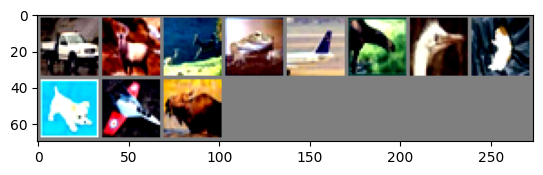

In [21]:
imshow(torchvision.utils.make_grid(data))

In [22]:
! pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=54f8515fd848714e46f936df68ca2fd776db454659ce2c7c0ccfcb344d32f4c6
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [23]:
model.layer3[-1]

BasicBlock(
  (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (shortcut): Sequential()
)

In [24]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.layer4[-1]]
input_tensor = data# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [25]:
model(input_tensor.to(device)).shape

torch.Size([11, 10])

In [26]:
input_tensor.shape

torch.Size([11, 3, 32, 32])

In [27]:
np.max(np.float32(input_tensor[0,:].reshape([32, 32,3]))/255)

0.008074938

In [28]:
grayscale_cam = cam(input_tensor=input_tensor[0:1,:].to(device),)

# In this example grayscale_cam has only one image in the batch:
print(grayscale_cam.shape)
grayscale_cam = grayscale_cam[0, :]
print(grayscale_cam.shape)
visualization = show_cam_on_image(np.float32(input_tensor[0,:].reshape([32, 32,3]))/255, grayscale_cam, use_rgb=True)

(1, 32, 32)
(32, 32)


In [29]:
visualization.shape

(32, 32, 3)

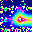

In [30]:
from PIL import Image
Image.fromarray(visualization)

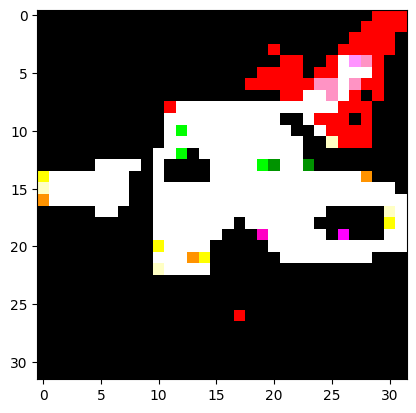

(None, tensor(8))

In [31]:
imshow(torchvision.utils.make_grid(input_tensor[0:1,:])*255),target[0]

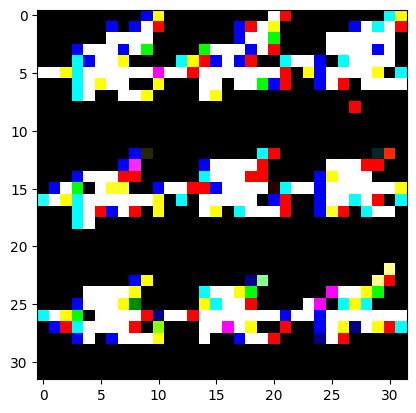

In [32]:
plt.imshow(input_tensor[0:1,:].reshape([32, 32,3])*255)

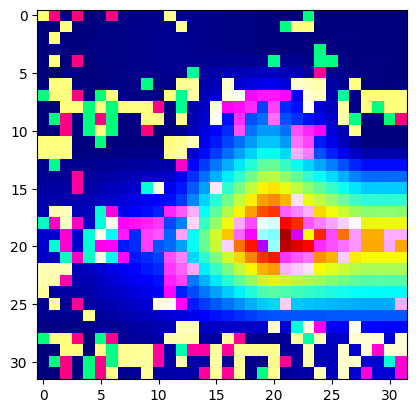

In [33]:
plt.imshow(visualization)

In [34]:
target_layers = [model.layer4[-1]]
input_tensor = data# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [35]:
#for index in range(11):
grayscale_cam = cam(input_tensor=input_tensor.to(device),)

# In this example grayscale_cam has only one image in the batch:
#print(grayscale_cam.shape)
#grayscale_cam = grayscale_cam[0, :]
#print(grayscale_cam.shape)
vl = []
for index in range(10):
    visualization = show_cam_on_image(np.float32(input_tensor[index,:].reshape([32, 32,3]))/255, \
                                  grayscale_cam[index, :], use_rgb=True)
    vl.append(visualization)

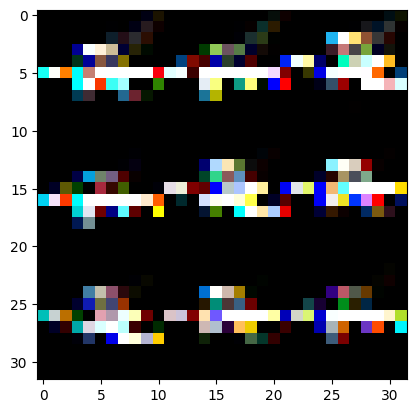

In [36]:
plt.imshow(input_tensor[0,:].reshape([32, 32,3]))

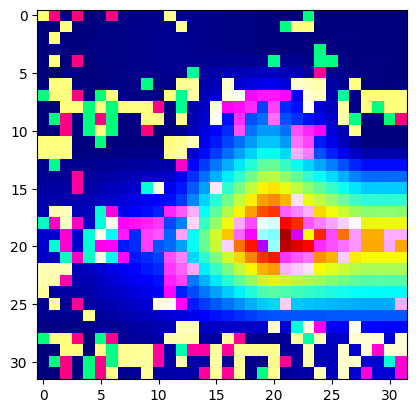

In [37]:
plt.imshow(vl[0])

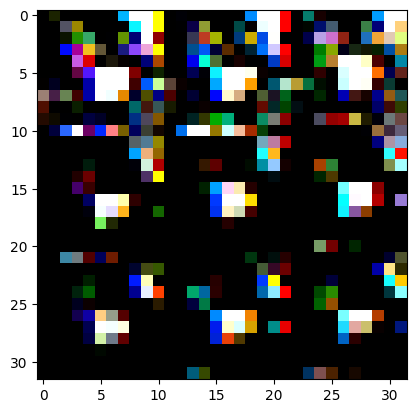

In [38]:
plt.imshow(input_tensor[1,:].reshape([32, 32,3]))

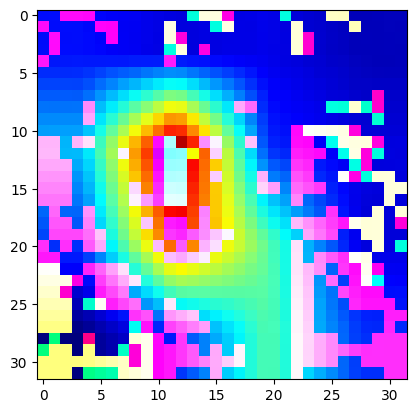

In [39]:
plt.imshow(vl[1])

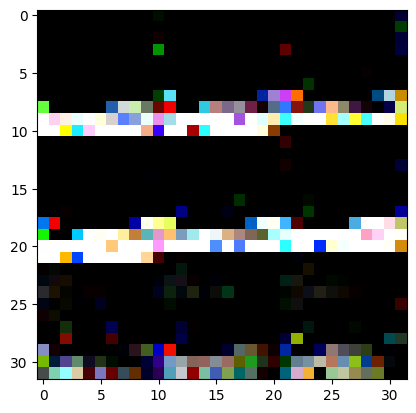

In [40]:
plt.imshow(input_tensor[2,:].reshape([32, 32,3]))

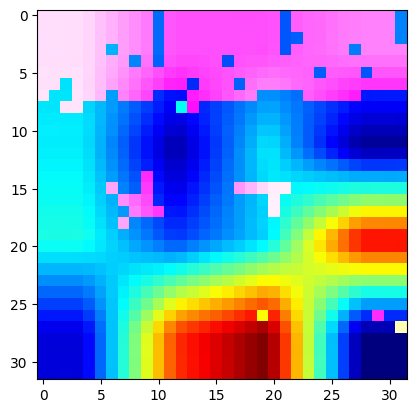

In [41]:
plt.imshow(vl[2])

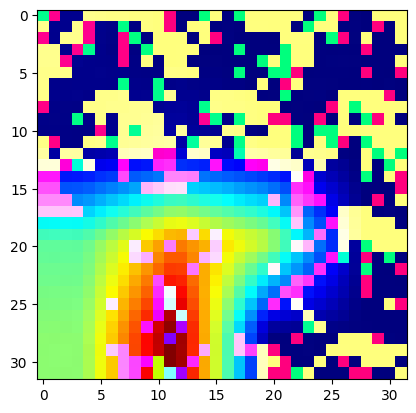

In [42]:
for i in vl:
    plt.imshow(i)